# Rell Autos

## Preprocessing Data

### Importing Libraries

In [1]:
!pip install pandas_profiling --quiet --disable-pip-version-check

In [2]:
!pip install fsspec==0.7.4 --quiet --disable-pip-version-check

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import os
import sklearn.model_selection
import pandas as pd

## SageMaker dependencies
import sagemaker
from sagemaker import get_execution_role
from sagemaker.image_uris import retrieve
from sagemaker.inputs import TrainingInput
from sagemaker.image_uris import retrieve
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import CSVDeserializer
import pickle
%matplotlib inline

In [4]:
#-


### Creating Sagemaker Session

In [ ]:
# This instantiates a SageMaker session that we will be operating in. 
session = sagemaker.Session()

# This object represents the IAM role that we are assigned.
role = sagemaker.get_execution_role()
print(role)

### Defining S3 Path

In [6]:
s3_bucket = 'aiml-machine-learning-debug'
s3_prefix = 'Car-Prices' #prefix used for data stored within the bucket
s3_path = 's3://{}/{}/'.format(s3_bucket, s3_prefix)

In [7]:
# Storing for further use
%store s3_path

Stored 's3_path' (str)


### Reading Dataset

In [ ]:
data_key = 'CarDetails.csv'
data_location = '{}{}'.format(s3_path, data_key)
data = pd.read_csv(data_location)

In [9]:
data.head()

name  year  selling_price  km_driven    fuel  \
0        Maruti Swift Dzire VDI  2014         450000     145500  Diesel   
1  Skoda Rapid 1.5 TDI Ambition  2014         370000     120000  Diesel   
2      Honda City 2017-2020 EXi  2006         158000     140000  Petrol   
3     Hyundai i20 Sportz Diesel  2010         225000     127000  Diesel   
4        Maruti Swift VXI BSIII  2007         130000     120000  Petrol   

  seller_type transmission         owner     mileage   engine   max_power  \
0  Individual       Manual   First Owner   23.4 kmpl  1248 CC      74 bhp   
1  Individual       Manual  Second Owner  21.14 kmpl  1498 CC  103.52 bhp   
2  Individual       Manual   Third Owner   17.7 kmpl  1497 CC      78 bhp   
3  Individual       Manual   First Owner   23.0 kmpl  1396 CC      90 bhp   
4  Individual       Manual   First Owner   16.1 kmpl  1298 CC    88.2 bhp   

                     torque  seats  
0            190Nm@ 2000rpm    5.0  
1       250Nm@ 1500-2500rpm    5.0  
2     12.7@ 2,700(kgm@ rpm)    5.0  
3  22.4 kgm at 1750-2750rpm    5.0  
4     11.5@ 4,500(kgm@ rpm)    5.0

#### Checking Missing Value

In [10]:
# We saw there were some missing values in the dataset
# Checking for missing values
def check_miss(data):
    '''
    data: requires a DataFrame object. 
    ---
    returns: A DataFrame with details about missing values
    '''
    cnull = [sum(data[y].isnull()) for y in data.columns]
    miss = pd.DataFrame({
        'Null Values': [any(data[x].isnull()) for x in data.columns],
        'Count_Nulls':
        cnull,
        'Percentage_Nulls':
        list((np.array(cnull) * 100) / data.shape[0]),
        'MValues':
        cnull,
        'Dtype':
        data.dtypes
    })
    return miss.sort_values(by='MValues', ascending=False)

In [11]:
check_miss(data)

Null Values  Count_Nulls  Percentage_Nulls  MValues    Dtype
torque                True          222          2.731299      222   object
mileage               True          221          2.718996      221   object
engine                True          221          2.718996      221   object
seats                 True          221          2.718996      221  float64
max_power             True          215          2.645177      215   object
name                 False            0          0.000000        0   object
year                 False            0          0.000000        0    int64
selling_price        False            0          0.000000        0    int64
km_driven            False            0          0.000000        0    int64
fuel                 False            0          0.000000        0   object
seller_type          False            0          0.000000        0   object
transmission         False            0          0.000000        0   object
owner                False            0          0.000000        0   object

#### Dealing with missing data:
- seats, engine, mileage, and max_power can be filled with a mean value

#### Processing Data
- Mileage can be converetd into numerical column
- Engine capacity can be converted into numermical column
- Max power can be converted into numerical column
- We do not have much use of torque column so we can drop the column
- We can have manufacturers from name column

In [12]:
# Keeping original data
orig_data=data.copy()

In [13]:
data.drop('torque',inplace=True,axis=1)

In [14]:
def get_value(data,cols):
    tata={i:[] for i in cols}
    for i in cols:
        for item in data[i]:
            if str(item)=='':
                tata[i].append(np.nan)
            if str(item)!='nan':
                tata[i].append(item.split(' ')[0])
            else:
                tata[i].append(np.nan)
    return tata

# This function will replace the original column with new columns of categories
def update_data(data, cols, dict_data):
    data.drop(cols, inplace=True, axis=1)
    for i in dict_data:
        data[i] = dict_data[i]
    return data

In [15]:
dict_data=get_value(data,['name','mileage','engine','max_power'])
data=update_data(data,['name','mileage','engine','max_power'],dict_data)

In [16]:
data.head()

year  selling_price  km_driven    fuel seller_type transmission  \
0  2014         450000     145500  Diesel  Individual       Manual   
1  2014         370000     120000  Diesel  Individual       Manual   
2  2006         158000     140000  Petrol  Individual       Manual   
3  2010         225000     127000  Diesel  Individual       Manual   
4  2007         130000     120000  Petrol  Individual       Manual   

          owner  seats     name mileage engine max_power  
0   First Owner    5.0   Maruti    23.4   1248        74  
1  Second Owner    5.0    Skoda   21.14   1498    103.52  
2   Third Owner    5.0    Honda    17.7   1497        78  
3   First Owner    5.0  Hyundai    23.0   1396        90  
4   First Owner    5.0   Maruti    16.1   1298      88.2

Now, we can fill the missing values. But before that we saw that data had around 14% of duplicate data. We will deal with the duplicate data.

### Dealing with Duplicated Data

In [17]:
data[data.duplicated()]

year  selling_price  km_driven    fuel seller_type transmission  \
291   2017         450000      35000  Petrol  Individual       Manual   
296   2012         330000      50000  Petrol  Individual       Manual   
370   2017        2625000       9000  Diesel      Dealer    Automatic   
371   2019        5150000      20000  Petrol      Dealer    Automatic   
372   2017        3200000      45000  Diesel      Dealer    Automatic   
...    ...            ...        ...     ...         ...          ...   
7987  2018        1265000      12000  Diesel  Individual       Manual   
7988  2019        1025000      32000  Diesel  Individual       Manual   
8117  2015         625000      50000  Diesel  Individual       Manual   
8126  2013         290000      25000  Diesel  Individual       Manual   
8127  2013         290000      25000  Diesel  Individual       Manual   

             owner  seats     name mileage engine max_power  
291    First Owner    5.0  Hyundai    18.9   1197        82  
296   Second Owner    5.0   Maruti    18.6   1197      85.8  
370    First Owner    5.0   Jaguar    13.6   1999       177  
371    First Owner    5.0    Lexus   22.37   2487    214.56  
372    First Owner    5.0   Jaguar   19.33   1999       177  
...            ...    ...      ...     ...    ...       ...  
7987   First Owner    5.0  Renault   20.37   1461    108.45  
7988   First Owner    5.0   Maruti   28.09   1248     88.50  
8117   First Owner    5.0   Maruti   26.59   1248        74  
8126   First Owner    5.0     Tata   23.57   1396        70  
8127   First Owner    5.0     Tata   23.57   1396        70  

[1221 rows x 12 columns]

In [18]:
data.drop_duplicates(inplace=True)

In [19]:
data.shape

(6907, 12)

In [20]:
check_miss(data)

Null Values  Count_Nulls  Percentage_Nulls  MValues    Dtype
seats                 True          208          3.011438      208  float64
mileage               True          208          3.011438      208   object
engine                True          208          3.011438      208   object
max_power             True          205          2.968003      205   object
year                 False            0          0.000000        0    int64
selling_price        False            0          0.000000        0    int64
km_driven            False            0          0.000000        0    int64
fuel                 False            0          0.000000        0   object
seller_type          False            0          0.000000        0   object
transmission         False            0          0.000000        0   object
owner                False            0          0.000000        0   object
name                 False            0          0.000000        0   object

Only, seats has empty values cause we replaced the empty value with -1 for other columns. This enables us to safely replace null values.

### Dealing with Null Values

In [21]:
def get_mean(data,cols):
    mean_data={i:None for i in cols}
    for i in cols:
        indices=data[data[i].isna()].index
        s=0
        for item in data.drop(indices,axis=0)[i]:
            if item!='': # max_power has empty strings still lying so we will avoid them
                s+=float(item)
        mean_data[i]=round(s/len(data.drop(indices,axis=0)[i]),3)
    return mean_data

In [22]:
mean_data=get_mean(data,['mileage','engine','max_power'])

In [23]:
print('Mean values: ',mean_data)

Mean values:  {'mileage': 19.464, 'engine': 1431.047, 'max_power': 87.735}


In [24]:
data.seats.fillna(data.seats.mode()[0],inplace=True)
data.mileage.fillna(mean_data['mileage'],inplace=True)
data.engine.fillna(mean_data['engine'],inplace=True)
data.max_power.fillna(mean_data['max_power'],inplace=True)

In [25]:
data.max_power.replace('',mean_data['max_power'],inplace=True)

In [26]:
check_miss(data)

Null Values  Count_Nulls  Percentage_Nulls  MValues    Dtype
year                 False            0               0.0        0    int64
selling_price        False            0               0.0        0    int64
km_driven            False            0               0.0        0    int64
fuel                 False            0               0.0        0   object
seller_type          False            0               0.0        0   object
transmission         False            0               0.0        0   object
owner                False            0               0.0        0   object
seats                False            0               0.0        0  float64
name                 False            0               0.0        0   object
mileage              False            0               0.0        0   object
engine               False            0               0.0        0   object
max_power            False            0               0.0        0   object

#### There are no missing values in data.

### Dealing with Outliers

<AxesSubplot:>

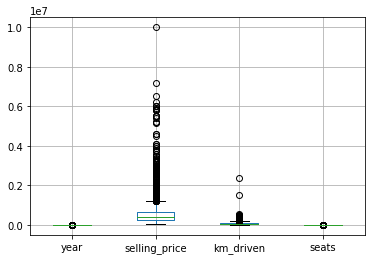

In [27]:
# we know that we can remove outliers using boxplot and IQR
data.boxplot()

#### Selling price and km_driven have alot of outliers

In [28]:
# Get quantiles using quantile function
Q1 = data['selling_price'].quantile(0.25)
Q3 = data['selling_price'].quantile(0.75)
IQR = Q3 - Q1

In [29]:
print('The IQR value is',IQR)

The IQR value is 384500.0


In [30]:
# Let's see which entries are outliers
outliers=data[(data.selling_price < (Q1 - 1.5 * IQR)) |(data.selling_price > (Q3 + 1.5 * IQR))]

In [31]:
outliers

year  selling_price  km_driven    fuel seller_type transmission  \
41    2019        2100000       5000  Petrol  Individual    Automatic   
47    2014        1500000      77000  Diesel      Dealer       Manual   
49    2014        1450000      27800  Diesel      Dealer    Automatic   
55    2016        1650000     127700  Diesel      Dealer    Automatic   
57    2013        1750000      33900  Diesel      Dealer    Automatic   
...    ...            ...        ...     ...         ...          ...   
7951  2018        1220000      11000  Petrol  Individual       Manual   
7963  2018        1265000      12000  Diesel  Individual       Manual   
7967  2011        1500000      84925  Diesel  Individual    Automatic   
8058  2017        1689999       8000  Petrol      Dealer    Automatic   
8108  2019        1575000      20000  Diesel  Individual    Automatic   

             owner  seats           name mileage engine max_power  
41     First Owner    5.0           Jeep    16.0   1368    160.77  
47     First Owner    7.0         Toyota   12.55   2982     168.5  
49    Second Owner    5.0  Mercedes-Benz    14.8   2143     120.7  
55    Second Owner    7.0         Toyota   11.36   2755     171.5  
57    Second Owner    5.0           Audi   17.68   1968    174.33  
...            ...    ...            ...     ...    ...       ...  
7951   First Owner    5.0        Hyundai    15.8   1591     121.3  
7963   First Owner    5.0        Renault   20.37   1461    108.45  
7967   First Owner    5.0            BMW   16.07   1995       181  
8058   First Owner    5.0           Audi    16.6   1798     177.5  
8108   First Owner    5.0            Kia    17.8   1493     113.4  

[327 rows x 12 columns]

In [32]:
# Dropping these entries
data.drop(outliers.index,axis=0,inplace=True)

##### Removing outliers from km_driven

In [33]:
# Get quantiles using quantile function
Q1 = data['km_driven'].quantile(0.25)
Q3 = data['km_driven'].quantile(0.75)
IQR = Q3 - Q1

In [34]:
print('The IQR value is',IQR)

The IQR value is 60000.0


In [35]:
# Let's see which entries are outliers
outliers=data[(data.km_driven < (Q1 - 1.5 * IQR)) |(data.km_driven > (Q3 + 1.5 * IQR))]

In [36]:
outliers

year  selling_price  km_driven    fuel seller_type transmission  \
272   2012         320000     193000  Diesel  Individual       Manual   
287   2007         210000     207890  Diesel  Individual       Manual   
394   2005         250000     240000  Diesel  Individual       Manual   
396   2009         340000     214000  Petrol  Individual       Manual   
397   2009         340000     214000  Diesel  Individual       Manual   
...    ...            ...        ...     ...         ...          ...   
8033  2012         450000     200000  Diesel  Individual       Manual   
8071  2010         425000     200000  Diesel  Individual       Manual   
8077  2009         550000     250000  Diesel  Individual       Manual   
8095  2012         260000     194000  Diesel  Individual       Manual   
8120  2008         120000     191000  Petrol  Individual       Manual   

             owner  seats      name mileage engine max_power  
272    First Owner    5.0    Maruti    19.3   1248      73.9  
287   Second Owner    7.0  Mahindra    13.6   2523        63  
394    Third Owner    8.0    Toyota    12.8   2494       102  
396   Second Owner    5.0   Hyundai    13.9   1599     103.2  
397   Second Owner    5.0   Hyundai    16.8   1493       110  
...            ...    ...       ...     ...    ...       ...  
8033  Second Owner    5.0   Hyundai   22.32   1582    126.32  
8071  Second Owner    7.0    Toyota    12.8   2494       102  
8077   First Owner    7.0    Toyota    12.8   2494       102  
8095   First Owner    5.0      Ford    20.0   1399        68  
8120   First Owner    5.0   Hyundai   17.92   1086      62.1  

[166 rows x 12 columns]

In [37]:
# Dropping these entries
data.drop(outliers.index,axis=0,inplace=True)

<AxesSubplot:>

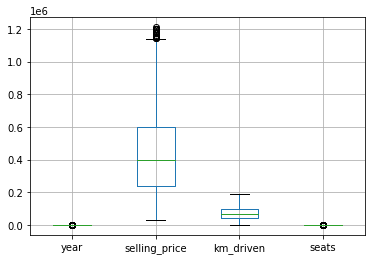

In [38]:
data.boxplot()

## Categorizing the year Column

In [39]:
max(data.year),min(data.year)

(2020, 1983)

year can be divided into 3 parts:
- vintage(<2000)
- old(<2015)
- new(>2015)

In [40]:
def type_year(item):
    if item<2000:
        return 'Vintage'
    elif item<2015:
        return 'Old'
    else:
        return 'New'

In [41]:
data['age_class']=data.year.apply(type_year)

In [42]:
data.head()

year  selling_price  km_driven    fuel seller_type transmission  \
0  2014         450000     145500  Diesel  Individual       Manual   
1  2014         370000     120000  Diesel  Individual       Manual   
2  2006         158000     140000  Petrol  Individual       Manual   
3  2010         225000     127000  Diesel  Individual       Manual   
4  2007         130000     120000  Petrol  Individual       Manual   

          owner  seats     name mileage engine max_power age_class  
0   First Owner    5.0   Maruti    23.4   1248        74       Old  
1  Second Owner    5.0    Skoda   21.14   1498    103.52       Old  
2   Third Owner    5.0    Honda    17.7   1497        78       Old  
3   First Owner    5.0  Hyundai    23.0   1396        90       Old  
4   First Owner    5.0   Maruti    16.1   1298      88.2       Old

## Encoding Data

In [43]:
cat_data=['fuel','seller_type','transmission','owner','seats','name','age_class']
norm_data=['km_driven','mileage','max_power','engine']

In [44]:
data=pd.get_dummies(data,columns=cat_data)

In [45]:
scl=StandardScaler()

In [46]:
data[norm_data]=scl.fit_transform(data[norm_data])

In [47]:
# Pickle the dummies data dictionary
dummies={'Cat_data':cat_data,'New_Cols':data.columns}
with open('dummies.pickle','wb') as file:
    pickle.dump(dummies,file)

In [48]:
# Pickle the scaler
with open('scaler.pickle','wb') as file:
    pickle.dump(scl,file)

### Processed Data

In [49]:
data.head()

year  selling_price  km_driven   mileage    engine  max_power  fuel_CNG  \
0  2014         450000   1.891153  0.943470 -0.292603  -0.382555         0   
1  2014         370000   1.248963  0.357073  0.279759   0.793768         0   
2  2006         158000   1.752642 -0.535495  0.277470  -0.223161         0   
3  2010         225000   1.425251  0.839683  0.046236   0.255019         0   
4  2007         130000   1.248963 -0.950643 -0.178130   0.183292         0   

   fuel_Diesel  fuel_LPG  fuel_Petrol  ...  name_Peugeot  name_Renault  \
0            1         0            0  ...             0             0   
1            1         0            0  ...             0             0   
2            0         0            1  ...             0             0   
3            1         0            0  ...             0             0   
4            0         0            1  ...             0             0   

   name_Skoda  name_Tata  name_Toyota  name_Volkswagen  name_Volvo  \
0           0          0            0                0           0   
1           1          0            0                0           0   
2           0          0            0                0           0   
3           0          0            0                0           0   
4           0          0            0                0           0   

   age_class_New  age_class_Old  age_class_Vintage  
0              0              1                  0  
1              0              1                  0  
2              0              1                  0  
3              0              1                  0  
4              0              1                  0  

[5 rows x 57 columns]

## Create Training and Testing Set

In [50]:
X = data.drop(['selling_price','year'],axis=1)
Y = data.selling_price

print("Features:", list(X.columns))
print("Dataset shape:", X.shape)
print("Dataset Type:", type(X))
print("Label set shape:", Y.shape)
print("Label set Type:", type(X))

Features: ['km_driven', 'mileage', 'engine', 'max_power', 'fuel_CNG', 'fuel_Diesel', 'fuel_LPG', 'fuel_Petrol', 'seller_type_Dealer', 'seller_type_Individual', 'seller_type_Trustmark Dealer', 'transmission_Automatic', 'transmission_Manual', 'owner_First Owner', 'owner_Fourth & Above Owner', 'owner_Second Owner', 'owner_Third Owner', 'seats_2.0', 'seats_4.0', 'seats_5.0', 'seats_6.0', 'seats_7.0', 'seats_8.0', 'seats_9.0', 'seats_10.0', 'seats_14.0', 'name_Ambassador', 'name_Audi', 'name_BMW', 'name_Chevrolet', 'name_Daewoo', 'name_Datsun', 'name_Fiat', 'name_Force', 'name_Ford', 'name_Honda', 'name_Hyundai', 'name_Isuzu', 'name_Kia', 'name_Mahindra', 'name_Maruti', 'name_Mercedes-Benz', 'name_Mitsubishi', 'name_Nissan', 'name_Opel', 'name_Peugeot', 'name_Renault', 'name_Skoda', 'name_Tata', 'name_Toyota', 'name_Volkswagen', 'name_Volvo', 'age_class_New', 'age_class_Old', 'age_class_Vintage']
Dataset shape: (6414, 55)
Dataset Type: <class 'pandas.core.frame.DataFrame'>
Label set shape: 

In [51]:
# We partition the dataset into 2/3 training and 1/3 test set.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=3)

# We further split the training set into a validation set i.e., 2/3 training set, and 1/3 validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2,random_state=3)

### Saving the sets:

In [52]:
pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(s3_path, 'train.csv'), header=False, index=False)
pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(s3_path, 'validation.csv'), header=False, index=False)

In [53]:
pd.concat([Y_test, X_test], axis=1).to_csv(os.path.join(s3_path, 'testing.csv'), header=False, index=False)

##### Pickle the testing columns for webapp

In [74]:
with open('test_columns.pickle','wb') as file:
    pickle.dump(list(X_test.columns),file)

## Training Models

In [54]:
s3_input_train = TrainingInput(s3_data=os.path.join(s3_path, 'train.csv'), content_type='text/csv')
s3_input_validation = TrainingInput(s3_data=os.path.join(s3_path, 'validation.csv'), content_type='text/csv')
s3_input_test = TrainingInput(s3_data=os.path.join(s3_path, 'testing.csv'), content_type='text/csv')

In [55]:
# Select between xgboost or linear-learner (regression)
models = ['xgboost', 'linear-learner']
model_selected = "linear-learner"
assert model_selected in models
print("Selected model:", model_selected)

Selected model: linear-learner


In [56]:
container = retrieve(framework=model_selected, region=session.boto_region_name, version='latest')
model = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path=s3_path,
                                    sagemaker_session=session)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


## Set Hyperparameters

you can also set your own hyperparameter and tune the model for better predictions. Following are some interesting parameters that you would like to set and check the results:

- XGBoost 
            ╔═══════════════════╦═══════════════════════════╦══════════════════════════════╗
            ║ Parameter Name    ║ Parameter Type            ║ Recommended Ranges           ║
            ╠═══════════════════╬═══════════════════════════╬══════════════════════════════╣
            ║ alpha             ║ ContinuousParameterRanges ║ MinValue: 0, MaxValue: 1000  ║
            ╠═══════════════════╬═══════════════════════════╬══════════════════════════════╣
            ║ colsample_bylevel ║ ContinuousParameterRanges ║ MinValue: 0.1, MaxValue: 1   ║
            ╠═══════════════════╬═══════════════════════════╬══════════════════════════════╣
            ║ colsample_bynode  ║ ContinuousParameterRanges ║ MinValue: 0.1, MaxValue: 1   ║
            ╠═══════════════════╬═══════════════════════════╬══════════════════════════════╣
            ║ colsample_bytree  ║ ContinuousParameterRanges ║ MinValue: 0.5, MaxValue: 1   ║
            ╠═══════════════════╬═══════════════════════════╬══════════════════════════════╣
            ║ eta               ║ ContinuousParameterRanges ║ MinValue: 0.1, MaxValue: 0.5 ║
            ╠═══════════════════╬═══════════════════════════╬══════════════════════════════╣
            ║ gamma             ║ ContinuousParameterRanges ║ MinValue: 0, MaxValue: 5     ║
            ╠═══════════════════╬═══════════════════════════╬══════════════════════════════╣
            ║ lambda            ║ ContinuousParameterRanges ║ MinValue: 0, MaxValue: 1000  ║
            ╠═══════════════════╬═══════════════════════════╬══════════════════════════════╣
            ║ max_delta_step    ║ IntegerParameterRanges    ║ [0, 10]                      ║
            ╠═══════════════════╬═══════════════════════════╬══════════════════════════════╣
            ║ max_depth         ║ IntegerParameterRanges    ║ [0, 10]                      ║
            ╠═══════════════════╬═══════════════════════════╬══════════════════════════════╣
            ║ min_child_weight  ║ ContinuousParameterRanges ║ MinValue: 0, MaxValue: 120   ║
            ╠═══════════════════╬═══════════════════════════╬══════════════════════════════╣
            ║ num_round         ║ IntegerParameterRanges    ║ [1, 4000]                    ║
            ╠═══════════════════╬═══════════════════════════╬══════════════════════════════╣
            ║ subsample         ║ ContinuousParameterRanges ║ MinValue: 0.5, MaxValue: 1   ║
            ╚═══════════════════╩═══════════════════════════╩══════════════════════════════╝

for more information on xgboost: https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html

- Linear Learner
            ╔═══════════════════╦═══════════════════════════╦══════════════════════════════╗
            ║ Parameter Name    ║ Parameter Type            ║ Recommended Ranges           ║
            ╠═══════════════════╬═══════════════════════════╬══════════════════════════════╣
            ║ alpha             ║ ContinuousParameterRanges ║ MinValue: 0, MaxValue: 1000  ║
            ╠═══════════════════╬═══════════════════════════╬══════════════════════════════╣
            ║ colsample_bylevel ║ ContinuousParameterRanges ║ MinValue: 0.1, MaxValue: 1   ║
            ╠═══════════════════╬═══════════════════════════╬══════════════════════════════╣
            ║ colsample_bynode  ║ ContinuousParameterRanges ║ MinValue: 0.1, MaxValue: 1   ║
            ╠═══════════════════╬═══════════════════════════╬══════════════════════════════╣
            ║ colsample_bytree  ║ ContinuousParameterRanges ║ MinValue: 0.5, MaxValue: 1   ║
            ╠═══════════════════╬═══════════════════════════╬══════════════════════════════╣
            ║ eta               ║ ContinuousParameterRanges ║ MinValue: 0.1, MaxValue: 0.5 ║
            ╠═══════════════════╬═══════════════════════════╬══════════════════════════════╣
            ║ gamma             ║ ContinuousParameterRanges ║ MinValue: 0, MaxValue: 5     ║
            ╠═══════════════════╬═══════════════════════════╬══════════════════════════════╣
            ║ lambda            ║ ContinuousParameterRanges ║ MinValue: 0, MaxValue: 1000  ║
            ╠═══════════════════╬═══════════════════════════╬══════════════════════════════╣
            ║ max_delta_step    ║ IntegerParameterRanges    ║ [0, 10]                      ║
            ╠═══════════════════╬═══════════════════════════╬══════════════════════════════╣
            ║ max_depth         ║ IntegerParameterRanges    ║ [0, 10]                      ║
            ╠═══════════════════╬═══════════════════════════╬══════════════════════════════╣
            ║ min_child_weight  ║ ContinuousParameterRanges ║ MinValue: 0, MaxValue: 120   ║
            ╠═══════════════════╬═══════════════════════════╬══════════════════════════════╣
            ║ num_round         ║ IntegerParameterRanges    ║ [1, 4000]                    ║
            ╠═══════════════════╬═══════════════════════════╬══════════════════════════════╣
            ║ subsample         ║ ContinuousParameterRanges ║ MinValue: 0.5, MaxValue: 1   ║
            ╚═══════════════════╩═══════════════════════════╩══════════════════════════════╝
        
for more information on linear-learner: https://docs.aws.amazon.com/sagemaker/latest/dg/linear-learner.html

In [58]:
if model_selected == "xgboost":
    model.set_hyperparameters(max_depth=10,
                            eta=0.2,
                            gamma=4,
                            min_child_weight=6,
                            subsample=0.8,
                            objective='reg:linear',
                            early_stopping_rounds=10,
                            num_round=2)
# Feature_dim is feature dimensions where 55 is the number of features we have. If in any case you make any change
# in the processing part of the data please ensure that this number is same as the number of features in X_train.
if model_selected == 'linear-learner':
    model.set_hyperparameters(feature_dim=X_test.shape[1],
                           predictor_type='regressor',
                           mini_batch_size=100)

In [59]:
model.fit({'train': s3_input_train, 'validation': s3_input_validation,'test':s3_input_test}, wait=True,)

2020-12-16 04:12:59 Starting - Starting the training job...
2020-12-16 04:13:22 Starting - Launching requested ML instancesProfilerReport-1608091978: InProgress
......
2020-12-16 04:14:25 Starting - Preparing the instances for training.........
2020-12-16 04:15:47 Downloading - Downloading input data...
2020-12-16 04:16:25 Training - Downloading the training image...
2020-12-16 04:16:45 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/16/2020 04:16:48 INFO 140498388645696] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_l

### Creating Endpoint

In [60]:
%%time
predictor=model.deploy(initial_instance_count=1, instance_type='ml.t2.medium',use_compiled_model=False,
                       serializer=CSVSerializer(),deserializer=CSVDeserializer())

-------------!CPU times: user 256 ms, sys: 1.08 ms, total: 257 ms
Wall time: 6min 31s


In [61]:
y_pred = predictor.predict(np.array(X_test))

In [62]:
Y_test=Y_test.astype(float)
if model_selected=='linear-learner':
    list_Y_pred=[]
    for each in y_pred:
        list_Y_pred.append(each[0])
    y_pred=list_Y_pred
    print('R2 Score for Linear model: ', r2_score(Y_test, np.array(y_pred,float)))
else:
    print('R2 Score for XGBoost model: ', r2_score(Y_test, np.array(y_pred[0],float)))

R2 Score for Linear model:  0.7415090206788757


### Delete Endpoint

In [75]:
predictor.delete_endpoint()

## Clean Up 

To avoid incurring unnecessary charges following steps should be followed:
https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-cleanup.html